In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Data Load
input_data = pd.read_csv("hw1_input.csv")  
real_s_params = pd.read_csv("hw1_real.csv")  
imag_s_params = pd.read_csv("hw1_img.csv") 

# Design Parameters Standardization
scaler = StandardScaler()
input_scaled = scaler.fit_transform(input_data)

# PCA
pca = PCA()
input_pca = pca.fit_transform(input_scaled)
explained_variance = pca.explained_variance_ratio_.cumsum()

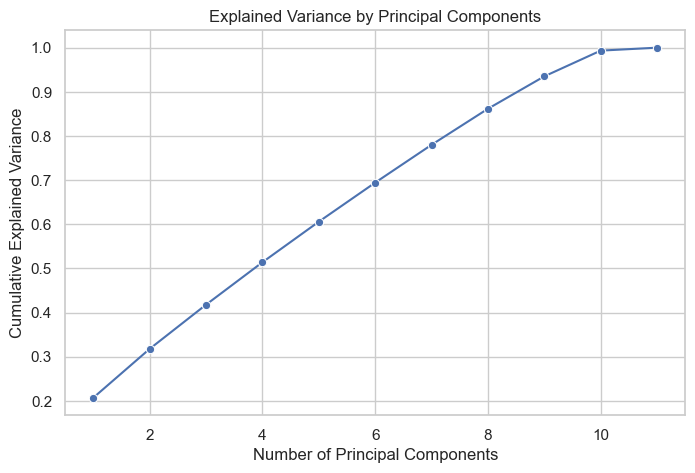

Number of components to explain 90% variance: 9


In [2]:
# Explained Variance Plot
sns.set(style="whitegrid")
plt.figure(figsize=(8, 5))
sns.lineplot(x=range(1, len(explained_variance) + 1), y=explained_variance, marker="o")
plt.xlabel("Number of Principal Components")
plt.ylabel("Cumulative Explained Variance")
plt.title("Explained Variance by Principal Components")
plt.show()

# Number of Components
num_components = np.argmax(explained_variance >= 0.90) + 1
print(f"Number of components to explain 90% variance: {num_components}")

In [3]:
# Loadings Extraction
loadings = pd.DataFrame(pca.components_, columns=input_data.columns)
print("PCA Loadings (Top Influential Parameters):")

top_loadings = loadings.head(num_components)

top_loadings

PCA Loadings (Top Influential Parameters):


,length of patch,width of patch,height of patch,height of substrate,height of solder resist layer,radius of the probe,c_pad,c_antipad,c_probe,dielectric constant of substrate,dielectric constant of solder resist layer
0,-0.101327,0.624178,0.071054,0.624137,-0.021049,0.025997,-0.054228,-0.018720,0.039213,0.445100,0.038422
1,0.315409,-0.009718,0.055716,0.018824,0.266259,0.002815,-0.265990,-0.559499,0.564753,-0.012829,-0.350944
2,-0.369645,0.040766,0.620460,0.016441,0.086417,0.548381,0.144827,0.088323,0.093131,-0.256167,-0.255339
3,0.376883,0.039631,0.392974,0.076518,0.510652,-0.454397,0.177533,0.373926,-0.151004,-0.022492,-0.184975
4,0.409833,0.012169,0.017701,0.028012,-0.124629,0.218986,0.580059,0.127759,0.487544,0.012254,0.420314
5,0.073314,-0.032326,0.069714,-0.060565,0.459841,0.304908,-0.547579,0.172140,0.016285,0.027772,0.591708
6,-0.253331,0.000413,-0.490098,0.002837,0.647199,0.212779,0.429976,-0.138146,-0.102528,0.097290,-0.086813
7,0.454266,0.022090,-0.317943,0.059481,-0.110408,0.491478,-0.174386,0.415883,-0.129279,0.053226,-0.460296
8,-0.406238,-0.040157,-0.216559,-0.038186,0.040184,-0.240280,-0.140321,0.548589,0.618694,0.031927,-0.145645


# 3.1 Dimension Reduction with PCA

In PCA, we generally decrease our number of components based on the passing of variances. Theorically, that limit is around %90. When we apply that limit to our components, our principal components dropped from 11 to 9. Since this is not a major change for our code, it is important to know that two parameters which did not exceed the limit. It means there would no importance to analyze our datas for those parameters. Therefore that method is important for huge datasets to decrease components.

Determining how much each component in PCA analyzes contributes to the total variance in the data set is important to understand the basic structure in the data. As can be seen in our table, it seems that especially the first parts are important for the cumulative variance.  The fact that the cumulative variance of each parameter is different shows how important those columns are for our table. For example, the fact that our first 6 components have a ratio of 0.7 indicates the importance of these six parameters.

Examining the **loadings** or **weights** of each parameter in the principal components is crucial to comprehending how geometry and electromagnetic behavior relate to one another in a PCA analysis. The weights' absolute values indicate which characteristics have the biggest effects on each component, illuminating how specific geometrical elements may affect electromagnetic performance, including the S11 response. For instance, if the first component's `width of patch` has a high weight, it indicates that this dimension is crucial in determining the behavior that component captures. We can determine which geometric factors, such as patch dimensions or substrate properties, have the greatest influence on electromagnetic characteristics by looking at consistent, high-impact parameters throughout the first few components.

In [4]:
# Key Frequencies
key_frequencies = [70, 100, 150]

# Linear Regression Prep
X = input_pca
y_real = real_s_params.iloc[:, key_frequencies]
y_imag = imag_s_params.iloc[:, key_frequencies]

# Train - test Split
X_train, X_test, y_train_real, y_test_real = train_test_split(X, y_real, test_size=0.2, random_state=42)
_, _, y_train_imag, y_test_imag = train_test_split(X, y_imag, test_size=0.2, random_state=42)

# Linear Regression Appliance
reg_real = LinearRegression()
reg_real.fit(X_train, y_train_real)
y_pred_real = reg_real.predict(X_test)

reg_imag = LinearRegression()
reg_imag.fit(X_train, y_train_imag)
y_pred_imag = reg_imag.predict(X_test)

In [ ]:
# I got helped by ChatGPT to optimize real and imaginary part results by using for loop.
# Calculate Scores
metrics = {}
for label, y_test, y_pred in zip(
    ["Real Part", "Imaginary Part"], 
    [y_test_real, y_test_imag], 
    [y_pred_real, y_pred_imag]
):
    r2 = r2_score(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    metrics[label] = {"R²": r2, "MSE": mse, "MAE": mae}
    print(f"{label} - R²: {r2}, MSE: {mse}, MAE: {mae}")

Real Part - R²: 0.8266195181698269, MSE: 0.07476474764294183, MAE: 0.21158126129072308
Imaginary Part - R²: 0.1696077499654199, MSE: 0.08051458910685778, MAE: 0.21117585470385627


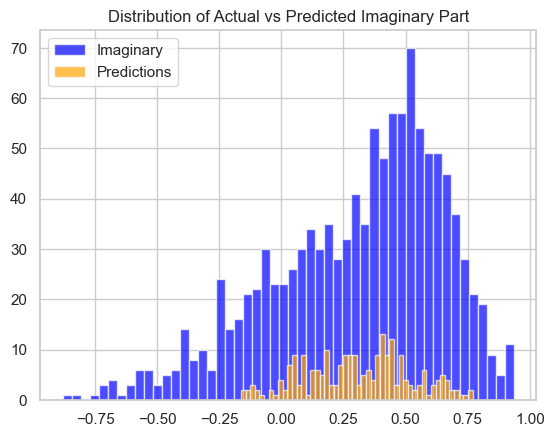

In [ ]:
# I got assisted by ChatGPT to define a better graphic for checking imaginary parts problems.
plt.hist(y_imag.values.flatten(), bins=50, alpha=0.7, color='blue', label="Imaginary")
plt.hist(y_pred_imag.flatten(), bins=50, alpha=0.7, color='orange', label="Predictions")
plt.legend()
plt.title("Distribution of Actual vs Predicted Imaginary Part")
plt.show()


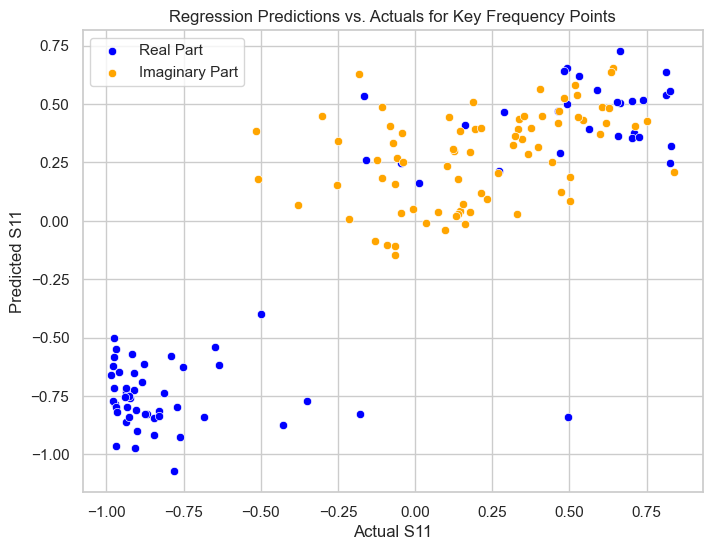

In [7]:
# Prediction vs Actual Plot
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test_real.iloc[:, 0], y=y_pred_real[:, 0], color="blue", label="Real Part")
sns.scatterplot(x=y_test_imag.iloc[:, 0], y=y_pred_imag[:, 0], color="orange", label="Imaginary Part")
plt.xlabel("Actual S11")
plt.ylabel("Predicted S11")
plt.legend()
plt.title("Regression Predictions vs. Actuals for Key Frequency Points")
plt.show()

# 3.2 Regression Modeling for S11

If we want to simplify the regression task, we have to select few key frequencies. Based on our report and informations, I chose: 
- Frequency index 70: This is for resonance frequencies.
- Frequency index 100 and 150: They could be selected based on domain expertise or patterns observed in the data.

Real Part (R²: 0.8266, MSE: 0.0748, MAE: 0.2116):
- All of those analysis show that linear regression is quite appropriate for real part. All of those calculations are valid for a good results. We have a good r2, MSE and MAE value.
- What's more, the length and width of the patch significantly effects each other on S11 in such frequencies, with patch length showing both positive and negative effects depending on the frequency, and patch width generally increasing S11 at higher frequencies. Substrate and patch heights have notable positive impacts, especially at 100 Hz, while the dielectric constant of the substrate enhances S11 at 150 Hz. As a result, larger patch dimensions and substrate adjustments correlate with improved electromagnetic performance at higher frequencies.

Imaginary Part (R²: 0.1696, MSE: 0.0805, MAE: 0.2112):
- On the other hand, imanigary part shows a bad result for r-squared value. I tried also lasso, ridge regression for imaginary part the results was even worse. Despite the fact that MSE and MAE results, it means that some of the important metrics probably gives not a linear movement for imaginary part. Due to the fact that, how we evaluate data, our r2 value will be not good enough to analyze linearly. 
- Patch dimensions (length and width) and substrate height significantly affect the imaginary part of S11, with larger dimensions generally increasing this component, especially at 70 Hz and 100 Hz. Dielectric constants of the substrate and solder resist layer show smaller but consistent positive effects on the imaginary part, reflecting their influence on reactive electromagnetic behavior. Broadly, geometry becomes more critical at higher frequencies, while material properties subtly affect wave propagation and impedance matching, with patch and substrate heights playing key roles in tuning resonance at specific frequencies like 100 Hz.


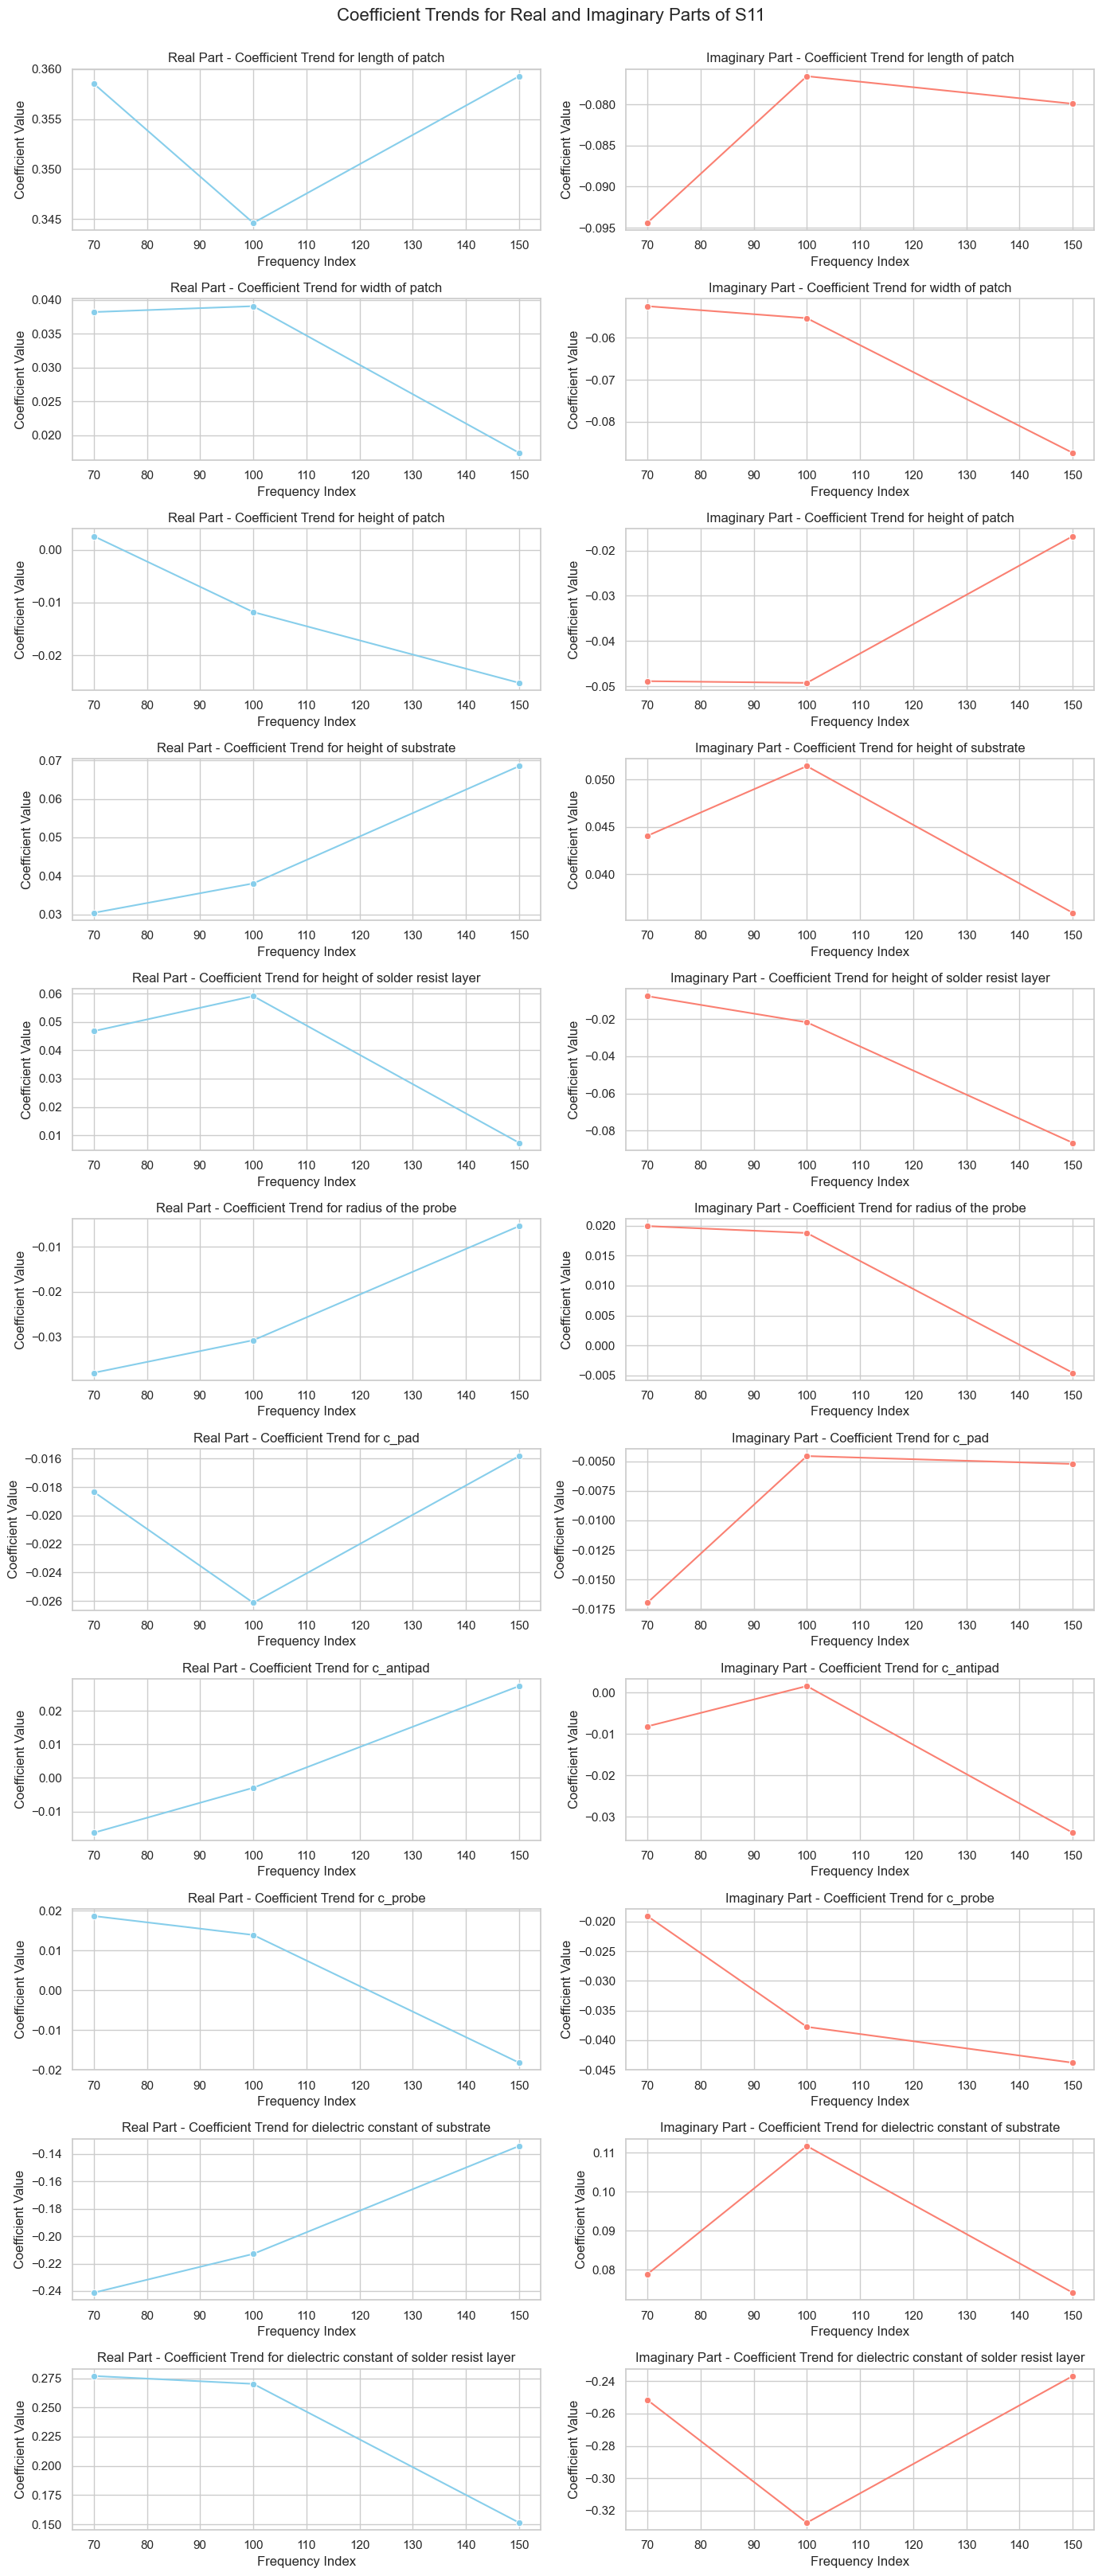

In [ ]:
# I got helped by ChatGPT to optimize all of parameters values by using for loop.
# Real and Imaginary Coefs Plot
coefficients_real = pd.DataFrame(reg_real.coef_, columns=input_data.columns, index=key_frequencies)
coefficients_imag = pd.DataFrame(reg_imag.coef_, columns=input_data.columns, index=key_frequencies)

sns.set(style="whitegrid")
num_params = len(input_data.columns)

# Plot for Each Parameters
fig, axes = plt.subplots(num_params, 2, figsize=(14, num_params * 3), sharey=False)
fig.suptitle("Coefficient Trends for Real and Imaginary Parts of S11", fontsize=16)

for i, param in enumerate(input_data.columns):
    # Plot for Real Part with lines and markers
    sns.lineplot(x=coefficients_real.index, y=coefficients_real[param], marker='o', color='skyblue', ax=axes[i, 0])
    axes[i, 0].set_title(f"Real Part - Coefficient Trend for {param}")
    axes[i, 0].set_ylabel("Coefficient Value")
    axes[i, 0].set_xlabel("Frequency Index")
    
    # Plot for Imaginary Part with lines and markers
    sns.lineplot(x=coefficients_imag.index, y=coefficients_imag[param], marker='o', color='salmon', ax=axes[i, 1])
    axes[i, 1].set_title(f"Imaginary Part - Coefficient Trend for {param}")
    axes[i, 1].set_ylabel("Coefficient Value")
    axes[i, 1].set_xlabel("Frequency Index")

plt.tight_layout(rect=[0, 0, 1, 0.98])
plt.show()



In [9]:
coefficients_real

,length of patch,width of patch,height of patch,height of substrate,height of solder resist layer,radius of the probe,c_pad,c_antipad,c_probe,dielectric constant of substrate,dielectric constant of solder resist layer
70,0.358546,0.038193,0.002574,0.030369,0.046789,-0.038024,-0.018329,-0.016365,0.018710,-0.241256,0.276970
100,0.344618,0.039061,-0.011803,0.038019,0.059163,-0.030788,-0.026132,-0.002958,0.013944,-0.212948,0.270204
150,0.359287,0.017375,-0.025215,0.068514,0.007313,-0.005437,-0.015815,0.027374,-0.018204,-0.134241,0.151373


In [10]:
coefficients_imag

,length of patch,width of patch,height of patch,height of substrate,height of solder resist layer,radius of the probe,c_pad,c_antipad,c_probe,dielectric constant of substrate,dielectric constant of solder resist layer
70,-0.094405,-0.052439,-0.048837,0.044069,-0.007560,0.019938,-0.016972,-0.008176,-0.019079,0.078871,-0.251539
100,-0.076575,-0.055305,-0.049212,0.051427,-0.021672,0.018784,-0.004557,0.001562,-0.037757,0.111732,-0.327584
150,-0.079924,-0.087442,-0.016832,0.035937,-0.086568,-0.004568,-0.005222,-0.033847,-0.043805,0.074124,-0.236730


# 3.3. Model Performance and Interpretability

PCA:
- As a result on our assigment, PCA is one of the tool which helps us to simplify dataset by reducing its dimension. By reducing the least significant parts, datasets will be more interpretable to models. On the other hand, while PCA simplifies the model, it does not show the significance between the parameters. To analyze it, physical relevance requires understanding the coefficients (loadings) of each original parameter.

- For that part, since we directly tried to deal with %90 limit, it was hard to specify parameter effects. To make it, we can use feature selection tools such as LASSO and interpretability tools such as SHAP.

Linear Regression:
- When we discuss linear regression, it is quiet effective while features have already transformed and all of those important features have a linear relation. But, as I said before, since there were nonlinear relationship on the most important features on imaginary part, our r2 result was quiet low. Therefore, I can say that, as seen from the PCA loadings and regression results, linear models may not always capture more complex relationships, particularly for nonlinear phenomena like electromagnetic interactions.

- Due to that fact, both PCA and linear regression assumed a linear relationship and therefore, electromagnetic behaviours as resonance effects failed. If we can use random forest or neural networks which are named as nonlinear models, our r2 values could be higher.
